In [20]:
from src.search_space.operations import *
from src.search_space.networks import *

In [21]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy import stats
from src.utils.utilities import *
from src.metrics.swap import SWAP
from src.datasets.utilities import get_datasets
from src.search_space.networks import *

# Settings for console outputs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

parser = argparse.ArgumentParser()

# general setting
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
SEED = 0
REPEATS = 8
INPUT_SAMPLE = 16



input_file = open("input_RGB_32_32_4frame.txt","r")
input_dim = 32
inputs = []
for input_data in input_file.readlines():
    if input_data == "":
        break

    data = input_data.split()
    data_list = []
    for color in range(3):
        color_list = []
        for i in range(input_dim):
            data_list_list = []
            for j in range(input_dim):
                data_list_list.append(int(data[color*input_dim*input_dim + i*input_dim + j]))
            color_list.append(data_list_list)
        data_list.append(color_list)

    # the input chennel
    inputs.append(data_list)
input_file.close()
inputs = torch.Tensor(inputs)

cuda


In [22]:
import random
from collections import namedtuple

# 定義基因型
Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')
PRIMITIVES = [
    'none',
    'max_pool_3x3',
    'avg_pool_3x3',
    'skip_connect',
    'sep_conv_3x3',
    'sep_conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
]

def random_genotype():

    steps=4
    
    def valid_random_ops(steps):
        ops = []
        for i in range(steps):
            op1 = (random.choice(PRIMITIVES), random.randint(0, i + 1))
            op2 = (random.choice(PRIMITIVES), random.randint(0, i + 1))
            ops.append(op1)
            ops.append(op2)
        return ops

    normal = valid_random_ops(steps)
    reduce = valid_random_ops(steps)
    normal_concat = list(range(2, 2 + steps))
    reduce_concat = list(range(2, 2 + steps))
    
    genotype = Genotype(normal=normal, normal_concat=normal_concat, reduce=reduce, reduce_concat=reduce_concat)
    
    return genotype

def evaluate_fitness(genotype):
    network = Network(3, 2, 3, eval(str(genotype)))
    network = network.to(device)
    swap = SWAP(model=network, inputs=inputs, device=device, seed=SEED)
    swap_score = []
    for _ in range(REPEATS):
        network = network.apply(network_weight_gaussian_init)
        swap.reinit()
        swap_score.append(swap.forward())
        swap.clear()
    return np.mean(swap_score)

def mutate(genotype):
    def mutate_ops(ops):
        i = random.randint(0, 7)
        if random.random() > 0.5:
            ops[i] = (random.choice(PRIMITIVES), ops[i][1])
        else:
            if i < 2:
                state = random.randint(0, 1)
            elif i < 4:
                state = random.randint(0, 2)
            elif i < 6:
                state = random.randint(0, 3)
            else:
                state = random.randint(0, 4)
            ops[i] = (random.choice(PRIMITIVES), state)
        return ops
    
    if random.random() > 0.5:
        return Genotype(
            normal=mutate_ops(genotype.normal),
            normal_concat=genotype.normal_concat,
            reduce=genotype.reduce,
            reduce_concat=genotype.reduce_concat
        )
    else:
        return Genotype(
            normal=genotype.normal,
            normal_concat=genotype.normal_concat,
            reduce=mutate_ops(genotype.reduce),
            reduce_concat=genotype.reduce_concat
        )

def crossover(parent1, parent2):
    def mix_ops(ops1, ops2):
        return [random.choice(pair) for pair in zip(ops1, ops2)]
    
    normal = mix_ops(parent1.normal, parent2.normal)
    reduce = mix_ops(parent1.reduce, parent2.reduce)
    
    return Genotype(normal=normal, normal_concat=parent1.normal_concat, reduce=reduce, reduce_concat=parent1.reduce_concat)

In [23]:
# 初始化種群
population_size = 12
# 遺傳演算法的參數
num_generations = 100
mutation_rate = 0.1
tournament_size = 4

best_fitness = -1
best_genotype = None
anytime_behavior = []
prev_score = 0

population = []
for _ in range(population_size):
    genotype = random_genotype()
    population.append((genotype, evaluate_fitness(genotype)))

In [24]:

# 遺傳演算法迴圈
for generation in range(num_generations):
    # print(f"swap-score: {best_fitness}")
    # 選擇父代
    new_population = []
    for _ in range(population_size):
        tournament = random.sample(population, tournament_size)
        tournament = sorted(tournament, key=lambda x: -x[1])
        parent1 = tournament[0][0]
        parent2 = tournament[1][0]
        child = crossover(parent1, parent2)
        if random.uniform(0, 1) < mutation_rate:
            child = mutate(child)
        new_population.append((child, evaluate_fitness(child)))
    # new_population = sorted(new_population, key=lambda x: -x[1])
    # population[-1] = new_population[0]

    population = population + new_population
    population = sorted(population, key=lambda x: -x[1])
    population = population[:population_size]
    
    # for gene in population:
    #     print(gene,end=" ")
    # print("")

    max_fitness = population[0][1]
    # max_index = fitnesses.index(max_fitness)
    if max_fitness > best_fitness:
        best_fitness = max_fitness
        best_genotype = population[0][0]

    anytime_behavior.append(population[0])
    # 打印當前世代的最佳適應度
    print(f"Generation {generation}: \nBest Fitness = {best_fitness} Genotype = {best_genotype}")
    print("score improve ",best_fitness - prev_score)
    prev_score = best_fitness

Generation 0: 
Best Fitness = 54974.375 Genotype = Genotype(normal=[('max_pool_3x3', 1), ('sep_conv_5x5', 0), ('sep_conv_5x5', 1), ('sep_conv_3x3', 1), ('sep_conv_3x3', 1), ('sep_conv_5x5', 2), ('sep_conv_3x3', 2), ('skip_connect', 0)], normal_concat=[2, 3, 4, 5], reduce=[('dil_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 2), ('skip_connect', 1), ('sep_conv_3x3', 2), ('avg_pool_3x3', 3), ('dil_conv_3x3', 1), ('sep_conv_3x3', 0)], reduce_concat=[2, 3, 4, 5])
score improve  54974.375
Generation 1: 
Best Fitness = 55033.0 Genotype = Genotype(normal=[('max_pool_3x3', 1), ('sep_conv_5x5', 0), ('sep_conv_5x5', 1), ('sep_conv_3x3', 1), ('sep_conv_3x3', 1), ('sep_conv_5x5', 2), ('sep_conv_3x3', 2), ('avg_pool_3x3', 2)], normal_concat=[2, 3, 4, 5], reduce=[('skip_connect', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 2), ('none', 2), ('sep_conv_3x3', 2), ('avg_pool_3x3', 3), ('dil_conv_3x3', 1), ('sep_conv_3x3', 0)], reduce_concat=[2, 3, 4, 5])
score improve  58.625
Generation 2: 
Best Fit

OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB. GPU 0 has a total capacity of 2.00 GiB of which 290.43 MiB is free. Of the allocated memory 679.45 MiB is allocated by PyTorch, and 58.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'anytime behavior')

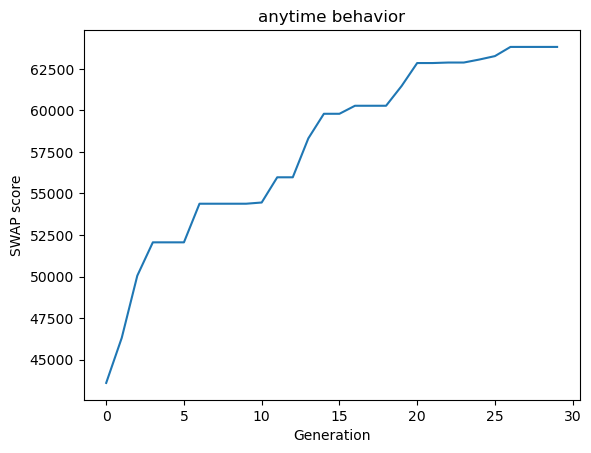

In [12]:

plt.plot(range(num_generations), [g[1] for g in anytime_behavior] )

plt.xlabel('Generation')
plt.ylabel('SWAP score')
plt.title('anytime behavior')

In [13]:
import wrapped_flappy_bird as game
import tensorflow as tf
import cv2
import numpy as np

ACTIONS = 2 

# print(s_t.shape)

best_score = []
for i in range(population_size//2):
    score_list = []
    for j in range(3):
        # print("st")
        game_state = game.GameState()


        #初始化状态并且预处理图片，把连续的四帧图像作为一个输入（State）
        do_nothing = np.zeros(ACTIONS)
        do_nothing[0] = 1
        s_t, r_0, terminal, _ = game_state.frame_step(do_nothing)
        framelist = [s_t, s_t, s_t, s_t]

        model = Network(3, 2, 15, population[i][0])
        s = 0
        while terminal !=True:
            a_t_to_game = np.zeros([ACTIONS])
            action_index = 0

            input = np.concatenate(framelist, axis=1)
            input = cv2.resize(input, (32, 32))
            input = torch.tensor(input, dtype=torch.float32)
            input = input.permute(2, 0, 1)
            input = input.unsqueeze(0)

            # print(input.shape)

            readout_t = model(input)
            action_index = np.argmax(readout_t.detach().cpu().numpy())
            a_t_to_game[action_index] = 1

            # print(f"action: {action_index}")

            s_t, r_t, terminal, score = game_state.frame_step(a_t_to_game)

            framelist = framelist[1:] + [s_t]


            # print("============== score ====================")
            # print(score)


            if score > s:
                s = score
        score_list.append(s)
        print(f"gene {i}, test {j}, score {score}")
    best_score.append(sum(score_list)/len(score_list))

gene 0, test 0, score 0
gene 0, test 1, score 0
gene 0, test 2, score 0
gene 1, test 0, score 0
gene 1, test 1, score 0
gene 1, test 2, score 0
gene 2, test 0, score 0
gene 2, test 1, score 0
gene 2, test 2, score 0
gene 3, test 0, score 0
gene 3, test 1, score 0
gene 3, test 2, score 0
gene 4, test 0, score 0
gene 4, test 1, score 0
gene 4, test 2, score 0
gene 5, test 0, score 0
gene 5, test 1, score 0
gene 5, test 2, score 0


In [8]:
print(best_score)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
